In [ ]:
import librosa
import numpy as np
np.random.seed(42)
import scipy
from keras.utils import Sequence, to_categorical
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

In [ ]:
sp_train = pd.read_csv('/content/drive/MyDrive/ETRI/sp_train.csv')
sp_test = pd.read_csv('/content/drive/MyDrive/ETRI/sp_test.csv')
li_train = pd.read_csv('/content/drive/MyDrive/ETRI/li_train.csv')  
li_test = pd.read_csv('/content/drive/MyDrive/ETRI/li_test.csv')

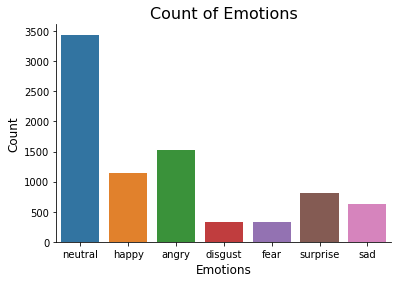

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotion',data=sp_train)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

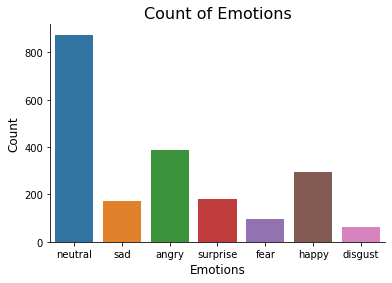

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotion',data=sp_test)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

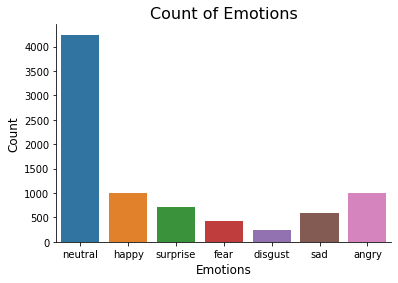

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotion',data=li_train)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

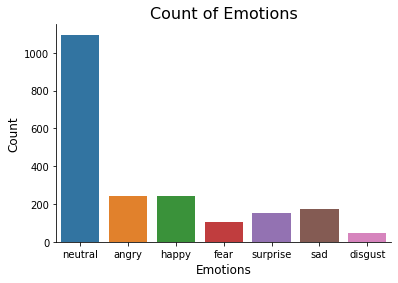

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotion',data=li_test)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Feature Extraction

# MFCC 2d conv

In [ ]:
sp_train = pd.read_csv('/content/drive/MyDrive/ETRI/sp_train.csv')
sp_test = pd.read_csv('/content/drive/MyDrive/ETRI/sp_test.csv')
li_train = pd.read_csv('/content/drive/MyDrive/ETRI/li_train.csv')  
li_test = pd.read_csv('/content/drive/MyDrive/ETRI/li_test.csv')

In [ ]:
sp_train = sp_train.replace({"happy": 0, "surprise": 1, "angry": 2, "neutral": 3, "disgust": 4, "fear": 5, "sad": 6})
sp_test = sp_test.replace({"happy": 0, "surprise": 1, "angry": 2, "neutral": 3, "disgust": 4, "fear": 5, "sad": 6})
li_train = li_train.replace({"happy": 0, "surprise": 1, "angry": 2, "neutral": 3, "disgust": 4, "fear": 5, "sad": 6})
li_test = li_test.replace({"happy": 0, "surprise": 1, "angry": 2, "neutral": 3, "disgust": 4, "fear": 5, "sad": 6})

In [ ]:
from scipy.io import wavfile
rate, data = wavfile.read('/content/drive/MyDrive/ETRI/KEMDy19/wav/Session01/Sess01_impro01/Sess01_impro01_F001.wav')
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  16000
Total samples (frames) =  (49962,)
[  38   32  -24 ... -392 -321 -240]


In [ ]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=7,
                 use_mfcc=False, n_folds=1, learning_rate=0.001, 
                 max_epochs=50, n_mfcc=100):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [ ]:
config = Config(sampling_rate=16000, audio_duration=2, n_folds=1, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=100)

In [ ]:
def prepare_data(df, config):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, path in enumerate(df.wav_path):
        print(path)
        data, _ = librosa.core.load(path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(y=data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

Speaker MFCC

In [ ]:
X_sp_train = prepare_data(sp_train, config)
X_sp_test = prepare_data(sp_test, config)

In [ ]:
mean = np.mean(X_sp_train, axis=0)
std = np.std(X_sp_train, axis=0)

X_sp_train = (X_sp_train - mean)/std
X_sp_test = (X_sp_test - mean)/std

In [ ]:
y_sp_train = to_categorical(sp_train.Emotion, num_classes=config.n_classes)

In [ ]:
y_sp_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_sp_test = to_categorical(sp_test.Emotion, num_classes=config.n_classes)
y_sp_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
np.save('/content/drive/MyDrive/ETRI/X_sp_train_2d.npy', X_sp_train)
np.save('/content/drive/MyDrive/ETRI/X_sp_test_2d.npy', X_sp_test)
np.save('/content/drive/MyDrive/ETRI/y_sp_train_2d.npy', y_sp_train)
np.save('/content/drive/MyDrive/ETRI/y_sp_test_2d.npy', y_sp_test)

Listener MFCC

In [ ]:
X_li_train = prepare_data(li_train, config)
X_li_test = prepare_data(li_test, config)

In [ ]:
mean = np.mean(X_li_train, axis=0)
std = np.std(X_li_train, axis=0)

X_li_train = (X_li_train - mean)/std
X_li_test = (X_li_test - mean)/std

In [ ]:
y_li_train = to_categorical(li_train.Emotion, num_classes=config.n_classes)

In [ ]:
y_li_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_li_test = to_categorical(li_test.Emotion, num_classes=config.n_classes)
y_li_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
np.save('/content/drive/MyDrive/ETRI/X_li_train_2d.npy', X_li_train)
np.save('/content/drive/MyDrive/ETRI/X_li_test_2d.npy', X_li_test)
np.save('/content/drive/MyDrive/ETRI/y_li_train_2d.npy', y_li_train)
np.save('/content/drive/MyDrive/ETRI/y_li_test_2d.npy', y_li_test)